<a href="https://colab.research.google.com/github/JonathanKulpa/Motion-Artifact-Signal-Generation-Toolkit/blob/Branch1/AR_Train_and_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AR Training and Simulation**

This python notebook allows you to use an Autoregressive (AR) model to output a simulated motion artifact signal.

You will need to have a sample file of motion artifact data so that the AR model can be trained.

If you plan on training the model and simulating a motion artifact signal from the model, run all the cells.

If you only plan on training the model, run the cells up until the beginning of Part 2.

If you plan on simulating a motion artifact signal using a model that was trained previously, run the following cell for loading the required libraries, and then continue running from Part 2.


In [ ]:
!pip install spectrum
from spectrum import aryule
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats, spatial, mean
from scipy.signal import butter, freqz
from scipy.fftpack import fft
import pandas as pd
import matplotlib.pylab as pylab
import string
import math
from google.colab import files
import io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Uploading Sample Signal and Preprocessing**

Load sample motion artifact and preprocessing

## Uploading Sample Motion Artifact Data
Choose the sample motion artifact data you would like to use to train the model. File must be in *.csv* format to upload.

There are two options to upload the file.

**Option 1: Upload directly from your PC**

Change the filename in the code to match the sample motion artifact data you would like to use to train the model. Once you run the code cell below, click on "*Choose Files*" and select the .csv file you would like to use.

In the cell below, change "*filename*" accordingly.

In [ ]:
uploaded  = files.upload()
data_save = pd.read_csv(io.BytesIO(uploaded['filename.csv']))

x= data_save["x"]
x = x.dropna()

Saving W_S1_85_Ch1.csv to W_S1_85_Ch1.csv


**Option 2: Upload from files saved on Google Drive**

Firstly, you will need to mount your Google Drive onto this Google Colab session.

This is done in the first code cell below. Upon running this cell you will be asked to sign into your Google account, from there you will need to copy a password and paste it back here in the Google Colab session. You will then be able to load and save files to your Google Drive directly from Google Colab.

In [ ]:
#Run this cell to mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Secondly, change the filename in the code below to match the sample motion artifact data you would like to use to train the model. You will also need to ensure the file path matches that of your file from your Google Drive.

In the cell below, change 'YOUR_FILE_NAME' and 'YOUR_FILE_PATH' accordingly.

In [ ]:
#Run this cell to download your specific filename
filename = "YOUR_FILE_NAME"
path = "/content/drive/My Drive/YOUR_FILE_PATH/{}.csv".format(filename)
data_save = pd.read_csv(path)

x= data_save["x"]
x = x.dropna()

## Preprocessing and Plotting

Adjust the sampling frequency by changing ***fs*** to match the sampling frequency of the input signal.

Text(0.5, 1.0, 'Input signal')

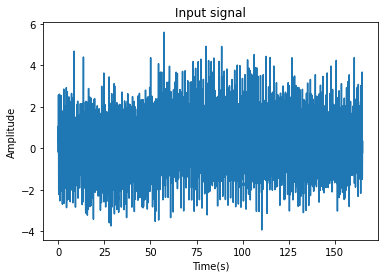

In [ ]:
fs = 2000
x = np.asarray(x)

length = np.size(x)
t_input = np.linspace(0, length/fs, length)

# Visualize the generated motion artifact signal over time
plt.plot(t_input, x)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Input signal')

###Lowpass Filter

In [ ]:
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

In [ ]:
# Setting standard filter requirements.

# Specify the order of the lowpass filter
order = 6
# Specify the cutoff frequency for the lowpass filter
cutoff = 10

y = butter_lowpass_filter(x, cutoff, fs, order)

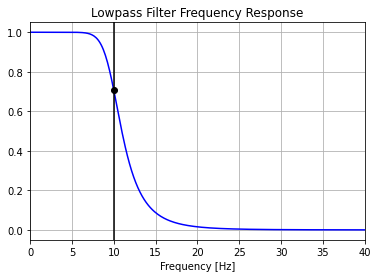

In [ ]:
b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response of the lowpass filter.
w, h = freqz(b, a, worN=8000)
#plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 40)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

###Power Normalization

In [ ]:
signal_power = np.sum(np.square(y))/len(y)
v = y/np.sqrt(signal_power)

### Downsample

Downsample the data by specifying your new sampling frequency of the output signal. The new sampling frequency is denoted by ***new_fs***.

In [ ]:
new_fs = 67 # New sampling frequency in Hz
df = fs/new_fs
z = signal.resample(v, int(len(v)/df))

###Plot Preprocessed Signal

In [ ]:
def find_psd(z, new_fs):
    f, Pxx_den = signal.welch(z, fs = new_fs, nperseg = len(z)/5)
    return(Pxx_den,f)

pxx, f = find_psd(z, new_fs)

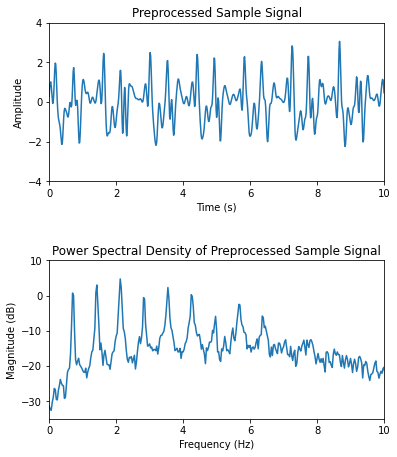

In [ ]:
#Plot preprocessed signal
length_z = np.size(z)
t_processed = np.linspace(0, length_z/new_fs, length_z)
#Preprocessed signal
plt.subplot(2,1,1)
plt.plot(t_processed, z)
plt.xlim([0,10]) #Set time values to zoom on a part of the input signal (seconds)
plt.ylim([-4,4]) #Adjust amplitude values for better viewing
plt.title('Preprocessed Sample Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

#Plot PSD plot of preprocessed signal
plt.subplot(2,1,2)
plt.plot(f, 10*np.log10(pxx))
plt.xlim([0,10]) #Frequency values (Hz) can be adjusted for better viewing
plt.ylim([-35,10]) #Magnitude values (dB) can be adjusted for better viewing
plt.title('Power Spectral Density of Preprocessed Sample Signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=0.5)

# **Part 1: Training**

## AR model training

**ARprocess** trains an AR model based on the uploaded signal.

Returns parameters of the trained AR model.

In [ ]:
def ARprocess(z):
  ar_params, var, coeff_reflection = aryule(z,90)
  return ar_params, var

ar_params, var = ARprocess(z)
print(ar_params)
print(var)

[-3.96380985e+00  6.68922419e+00 -5.31074098e+00  6.87776950e-01
  1.96080873e+00 -9.70325793e-01 -8.28143476e-02 -6.64283632e-01
  1.19845773e+00 -5.20713556e-01  1.16154128e-01 -4.74696299e-01
  5.70825857e-01 -2.18165286e-01  1.33607929e-01 -2.99985688e-01
  2.73597914e-01 -1.28305578e-01  1.35599034e-01 -1.83048539e-01
  1.48368218e-01 -1.06648773e-01  1.19690570e-01 -1.15011518e-01
  9.62477749e-02 -9.21595681e-02  1.00601351e-01 -8.26780428e-02
  7.05218021e-02 -7.67172505e-02  8.38136286e-02 -6.48607776e-02
  5.73266582e-02 -6.46725409e-02  6.96906152e-02 -5.32729875e-02
  4.94306114e-02 -5.40303723e-02  5.93231867e-02 -4.70436729e-02
  4.19406634e-02 -4.68115980e-02  5.28645216e-02 -3.82499620e-02
  3.83265855e-02 -4.42250162e-02  4.10348963e-02 -3.27087027e-02
  4.37166541e-02 -3.71711830e-02  2.89238970e-02 -3.46322034e-02
  4.19477570e-02 -2.57196762e-02  2.90529816e-02 -3.76945265e-02
  3.24187551e-02 -2.26482955e-02  3.05617012e-02 -2.99916161e-02
  3.12083721e-02 -2.86877

## Save the model parameters

*Optional:* Run this cell if you would like to save the model parameters to be able to generate a signal at another time.

After running the two cell below, the *ar_params.csv*, *var.csv* and *data_parameters.csv* files will be saved to your local device. These can be used to load the model and simulate a motion artifact at a later time.

In [ ]:
dfparameter1 = pd.DataFrame(ar_params)
dfparameter1.to_csv("ar_params.csv")

vars = [(var, 1)]
dfparameter2 = pd.DataFrame(vars)
dfparameter2.to_csv("var.csv")

data_parameters = [fs, new_fs]
dfparameter3 = pd.DataFrame(data_parameters)
dfparameter3.to_csv("data_parameters.csv")

print("Var = ")
print(var)
print("AR Parameters = ")
print(ar_params)
print("Data Parameters = ")
print(data_parameters)

Var = 
0.0003134775706749943
AR Parameters = 
[-3.96380985e+00  6.68922419e+00 -5.31074098e+00  6.87776950e-01
  1.96080873e+00 -9.70325793e-01 -8.28143476e-02 -6.64283632e-01
  1.19845773e+00 -5.20713556e-01  1.16154128e-01 -4.74696299e-01
  5.70825857e-01 -2.18165286e-01  1.33607929e-01 -2.99985688e-01
  2.73597914e-01 -1.28305578e-01  1.35599034e-01 -1.83048539e-01
  1.48368218e-01 -1.06648773e-01  1.19690570e-01 -1.15011518e-01
  9.62477749e-02 -9.21595681e-02  1.00601351e-01 -8.26780428e-02
  7.05218021e-02 -7.67172505e-02  8.38136286e-02 -6.48607776e-02
  5.73266582e-02 -6.46725409e-02  6.96906152e-02 -5.32729875e-02
  4.94306114e-02 -5.40303723e-02  5.93231867e-02 -4.70436729e-02
  4.19406634e-02 -4.68115980e-02  5.28645216e-02 -3.82499620e-02
  3.83265855e-02 -4.42250162e-02  4.10348963e-02 -3.27087027e-02
  4.37166541e-02 -3.71711830e-02  2.89238970e-02 -3.46322034e-02
  4.19477570e-02 -2.57196762e-02  2.90529816e-02 -3.76945265e-02
  3.24187551e-02 -2.26482955e-02  3.05617012

In [ ]:
#Download the files
files.download('ar_params.csv')
files.download('var.csv')
files.download('data_parameters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Part 2: Simulation**

## Load model parameters from a previously trained AR model

Once the cell below is run, click '*Choose Files*' and select the ***ar_params.csv*** file, followed by the ***var.csv*** file, and lastly, the ***data_parameters.csv*** file.  

**If you have just trained a model, you may skip the code cell below.**

In [ ]:
uploaded_ar_params = files.upload()
ar_params_csv = pd.read_csv("ar_params.csv")
ar_params_T = ar_params_csv.iloc[:,1]

ar_params = ar_params_T.T
ar_params = ar_params.to_numpy()

uploaded_var = files.upload()
var_csv = pd.read_csv("var.csv")
var = var_csv.iloc[0,1]

uploaded_data_parameters = files.upload()
data_parameters = pd.read_csv("data_parameters.csv", index_col=0)
fs = data_parameters.iloc[0,0]
new_fs = data_parameters.iloc[1,0]


Saving ar_params.csv to ar_params.csv


Saving var.csv to var.csv


Saving data_parameters.csv to data_parameters.csv


## AR Simulation

**ARgenerate** simulates data based on the trained AR model from ARprocess. Specify the length of the output signal by adjusting the value of ***output_length***, representing the length of the output signal in seconds (s).

Returns the simulated motion artifact signal.

In [ ]:
def ARgenerate(ar_params, var, output_length, new_fs, fs):
  ar_params = np.insert(ar_params,0,1)
  AR_output = signal.lfilter([1],ar_params,np.sqrt(var)*np.random.randn(1,output_length*new_fs))
  AR_data_20 = AR_output[0]
  #upsample data
  dataAR = AR_data_20
  down_factor = fs/new_fs
  dataAR = signal.resample(AR_data_20, int((AR_data_20.size)*down_factor))
  return dataAR

#Specify length of output (in seconds) by changing output_length
output_length = 200
dataAR = ARgenerate(ar_params, var, output_length, new_fs, fs)

## Visualize Simulated Motion Artifact

The cells below will allow you to view the output signal in the time domain as well as the power spectral density (PSD).

In [ ]:
def find_psd_out(x, fs):
    f, Pxx_den = signal.welch(x, fs = fs, nperseg = len(x)/5)
    return(Pxx_den,f)

pxx_out, f_out = find_psd_out(dataAR, fs)

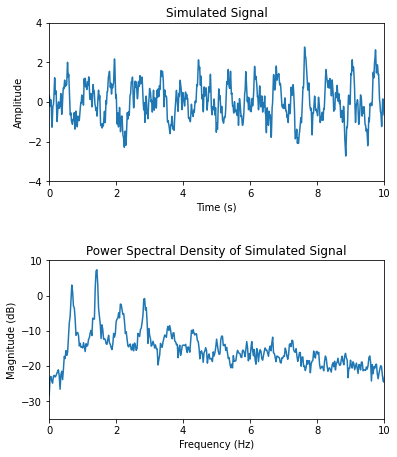

In [ ]:
#Plot output signal
t_output = np.linspace(0, dataAR.size/fs, dataAR.size)
#Preprocessed signal
plt.subplot(2,1,1)
plt.plot(t_output, dataAR)
plt.xlim([0,10]) #Set time values to zoom on a part of the input signal (seconds)
plt.ylim([-4,4]) #Adjust amplitude values for better viewing
plt.title('Simulated Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

#Plot low pass filtered and power normalized signal
#ORIGINAL SIGNAL
plt.subplot(2,1,2)
plt.plot(f_out, 10*np.log10(pxx_out))
plt.xlim([0,10]) #Frequency values (Hz) can be adjusted for better viewing
plt.ylim([-35,10]) #Magnitude values (dB) can be adjusted for better viewing
plt.title('Power Spectral Density of Simulated Signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=0.5)

# Save the Generated Motion Artifact Data

The simulated motion artifact signal can be saved in one of two ways.

**Option 1: Save simulated motion artifact data directly to computer**

In the cell below, change both instances of "***generated_signal***" to what you would like the file to be called. The file will be saved in *.csv* format.

In [ ]:
df = pd.DataFrame(dataAR)
df.to_csv("generated_signal.csv")
files.download("generated_signal.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Option 2: Save simulated motion artifact data to a file on Google Drive**

Change the filename to what you would like to save the file as. You will also need to change the file path to adjust where the file is saved within your Google Drive. If you have not yet done so, ensure your Google Drive is mounted onto this notebook as seen in the first cell of "Option 2" of "Uploading Sample Motion Artifact Data". The file will be saved in *.csv* format.

In the cell below, change 'NEW_FILE_NAME' and 'NEW_FILE_PATH' accordingly.

In [ ]:
df = pd.DataFrame(dataAR)
filename = "NEW_FILE_NAME"
df.to_csv("/content/drive/My Drive/NEW_FILE_PATH/{}.csv".format(filename))